In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from extraction_sm import *

# Data Acquisition

In [14]:
# let's process multiple files at once - I want some nicer statistic
# this is a time-ordered file of filenames for SM1 or SM2

fov = 2
# exclude calibration activities
pathfile = "split_filenames/filenames_sm{}_clean.txt".format(fov)


allfiles = []
f = open(pathfile, 'r')
allfiles = f.readlines()
f.close()

# strip away newlines and add absolute path prefix
allfiles = ["../../"+s.strip() for s in allfiles]


# select a few files - say some random date(s)
#mydates = ["2017-06-30","2017-07-01","2017-07-02","2017-07-03","2017-07-04"]
#mydates = ["2017-06-30"]
#mydates = ["2017-09-11"]

# get an entire month
year = 2014   # 2017
month = 8     # 6
mydates = ["{}-{:02d}-{:02d}".format(year,month,day) for day in range(32)] # Feb 31 does not exist, but we don't care

sourcefiles = []

for date in mydates:
    sourcefiles += [s for s in allfiles if date in s]

#sourcefiles = [sourcefiles[0]]  # if I want to use only one file
print("Using", len(sourcefiles), "files")

Using 0 files


In [12]:
out = []  # where our output will go
gains = []
rows = []
iobs = 0

# let's test the execution time
import time
timingstart = time.time()


for sourcefile in sourcefiles:
    print(iobs)
    iobs += 1
    (image,gain,bias,readnoise,fov,row,tstart,tstop) = sm_get_image(sourcefile, "../../datasets/sm_bias/sm_calibdat.fits")
    
    if (fov==1 and row==4):
        starmask = sm_starmask(image, 2000, badcol=850)
    else:
        starmask = sm_starmask(image, 2000)

    #output = sm_cosmics(image, gain, bias, readnoise, starmask, sigclip=10., sigfrac=0.3, objlim=10.)
    # tweaked parameters from the validation
    #output = sm_cosmics(image, gain, bias, readnoise, starmask, sigclip=10., sigfrac=0.1, objlim=25.)
    # additional tweaking to remove spurious background (always try to be above 2 sigma)
    output = sm_cosmics(image, gain, bias, readnoise, starmask, sigclip=10., sigfrac=0.1, objlim=25.)
    output.acqTime = tstart
    output.row = row
    output.fov = fov
    
    out.append(output)


timingend = time.time()
print("Elapsed time:", timingend - timingstart)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
Elapsed time: 532.6202220916748


# Saving the data

In [13]:
# time it
import time
tstart = time.time()


outfile = 'output/SM2_2014-09.fits'
write_Obslist(out, outfile)


tend = time.time()
print("Elapsed time:", tend - tstart)

Elapsed time: 16.17708659172058


# Reading Data

In [20]:
import time
tstart = time.time()

inlist = read_Obslist_fits('SM1_2017-08.fits')

tend = time.time()
print("Elapsed time:", tend - tstart)

Elapsed time: 11.910966157913208


# Some diagnostics

In [5]:
# Do some statistics

Etot = []

# also for lengths, why not
AL = []
AC = []

        
for ii in range(len(out)):
    Etot += list(out[ii].data["TRACK_EN"])
    AL += list(out[ii].data["DIM_AL"]-1)
    AC += list(out[ii].data["DIM_AC"]-1)


Etot = np.array(Etot)
AL = np.array(AL)
AC = np.array(AC)

#Eflare=[]
#for ii in range(len(inlist)):
#    Eflare += list(inlist[ii].data["TRACK_EN"])
#Eflare = np.array(Eflare)

        
# number of cosmics
print(len(Etot), "cosmics")


64381 cosmics


Energies

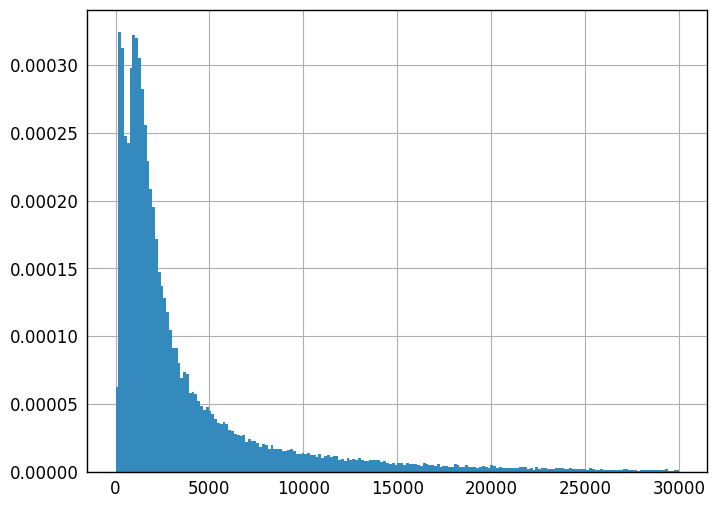

In [6]:
histE = plt.hist(Etot, 200, log=False ,range=(0,30000), normed=True)
#histEf = plt.hist(Eflare, 200, log=False ,range=(0,30000), normed=True,color="tab:red",histtype="stepfilled", alpha=0.6)

Lengths and angles

Weird thing: In a flare, this actually has the same maximum - although higher counts, especially where this one flattens off.

In [7]:
acqTimes = []

for ii in range(len(out)):
    acqTimes.append(out[ii].acqTime)
    
acqTimes = np.array(acqTimes)

First OBMT: 26848370000116700


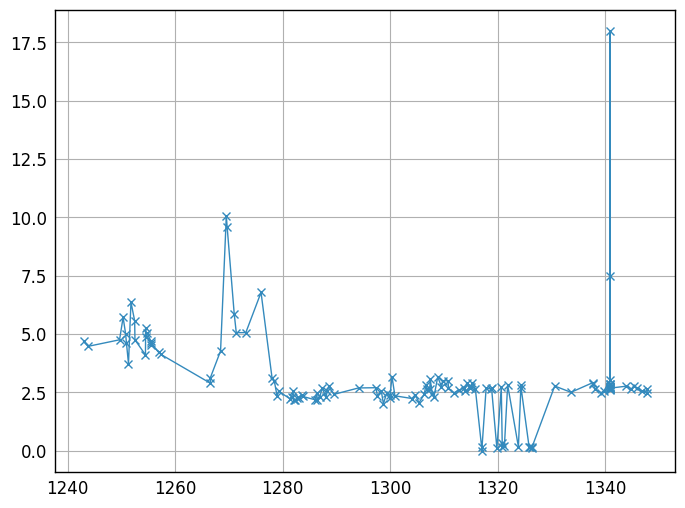

In [8]:
# fluxes
# I should group these by row
flux = [obs.calculate_flux() for obs in out]

plt.plot((acqTimes)/1e9/3600/6,flux,marker="x")

print("First OBMT:", acqTimes[0])

In [31]:
inlist1 = read_Obslist_fits('output/SM1_2017-08.fits')
inlist2 = read_Obslist_fits('output/SM2_2017-08.fits')

In [32]:
t1 = np.array([obs.acqTime for obs in inlist1])
t2 = np.array([obs.acqTime for obs in inlist2])

flux1 = np.array([obs.calculate_flux() for obs in inlist1])
flux2 = np.array([obs.calculate_flux() for obs in inlist2])

tcomb = list(t1)+list(t2)
fluxcomb = list(flux1)+list(flux2)

fluxcomb = [x for _,x in sorted(zip(tcomb,fluxcomb))]
tcomb.sort()

#fluxcomb.sort(key=tcomb)

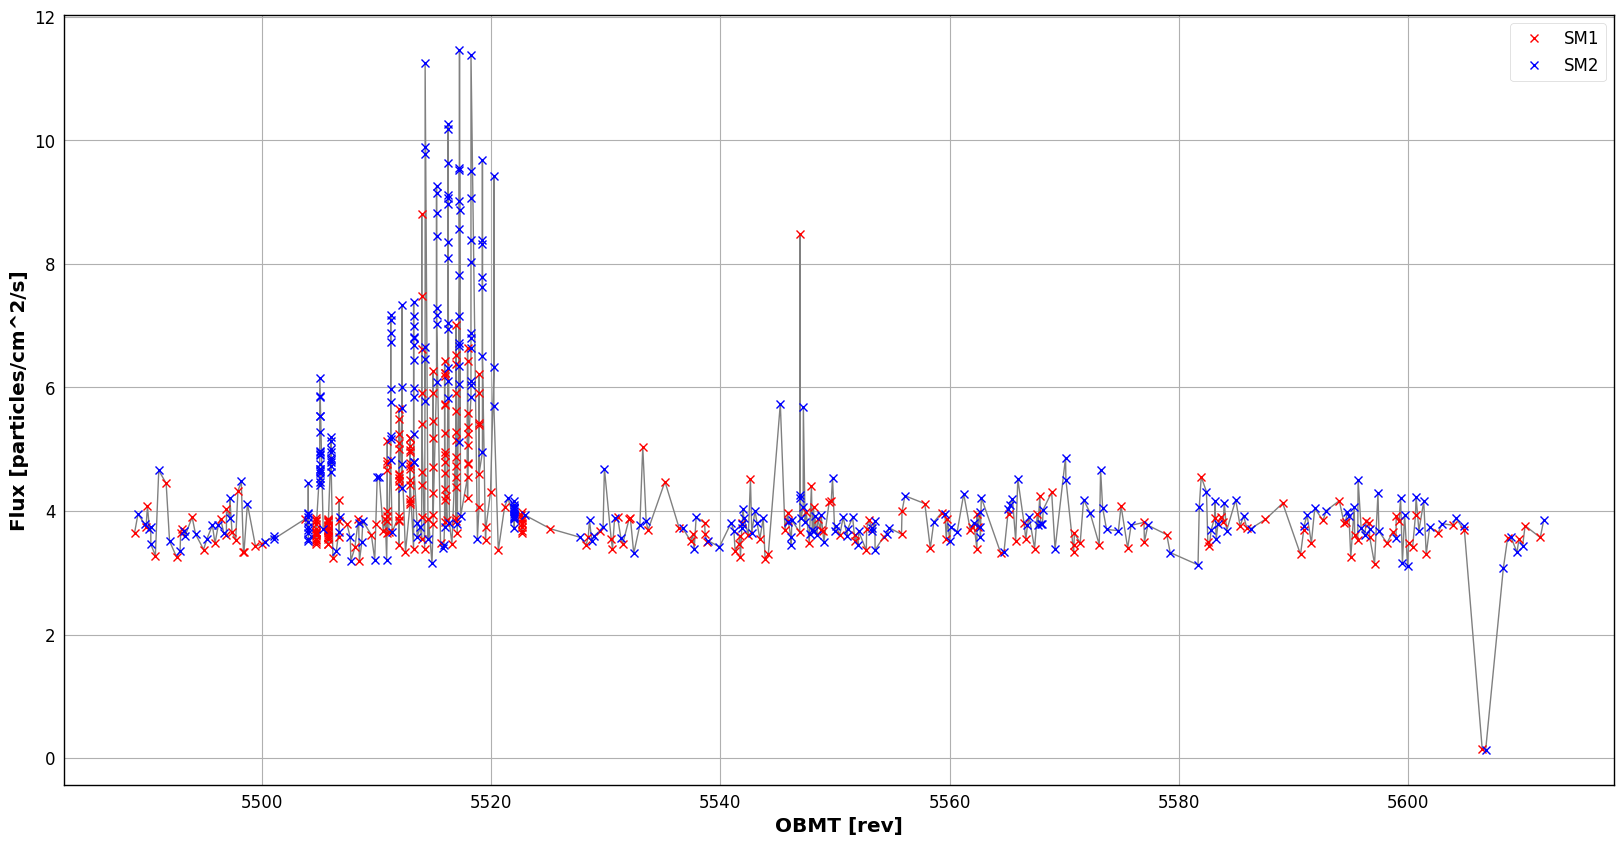

In [33]:
plt.plot(np.array(tcomb)/1e9/3600/6, fluxcomb, color='gray')

plt.plot((t1)/1e9/3600/6,flux1,marker="x", linestyle='', color='r', label="SM1")
plt.plot((t2)/1e9/3600/6,flux2,marker="x", linestyle='', color='b', label="SM2")
plt.legend(loc='best')

plt.xlabel("OBMT [rev]")
plt.ylabel("Flux [particles/cm^2/s]")
#plt.yscale("log")
#plt.xlim(5610,5630)
#plt.ylim(0,10)

plt.gcf().set_size_inches(20,10)

In [126]:
np.argmax(flux)

203

In [127]:
np.median(flux)

2.7999340638270023

In [42]:
# for fun - make a cosmic ray image from a TrackObs

iobs=128

obs = out[iobs]

obsimg = np.ones((obs.srcAL,obs.srcAC))

for ii in range(len(obs.data)):
    track = np.reshape(obs.data[ii]["TRACK"], (obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))
    start_AL = obs.data[ii]["LOC_AL"]
    stop_AL = obs.data[ii]["LOC_AL"] + obs.data[ii]["DIM_AL"]
    start_AC = obs.data[ii]["LOC_AC"]
    stop_AC = obs.data[ii]["LOC_AC"] + obs.data[ii]["DIM_AC"]
    obsimg[start_AL:stop_AL,start_AC:stop_AC] += track*gain

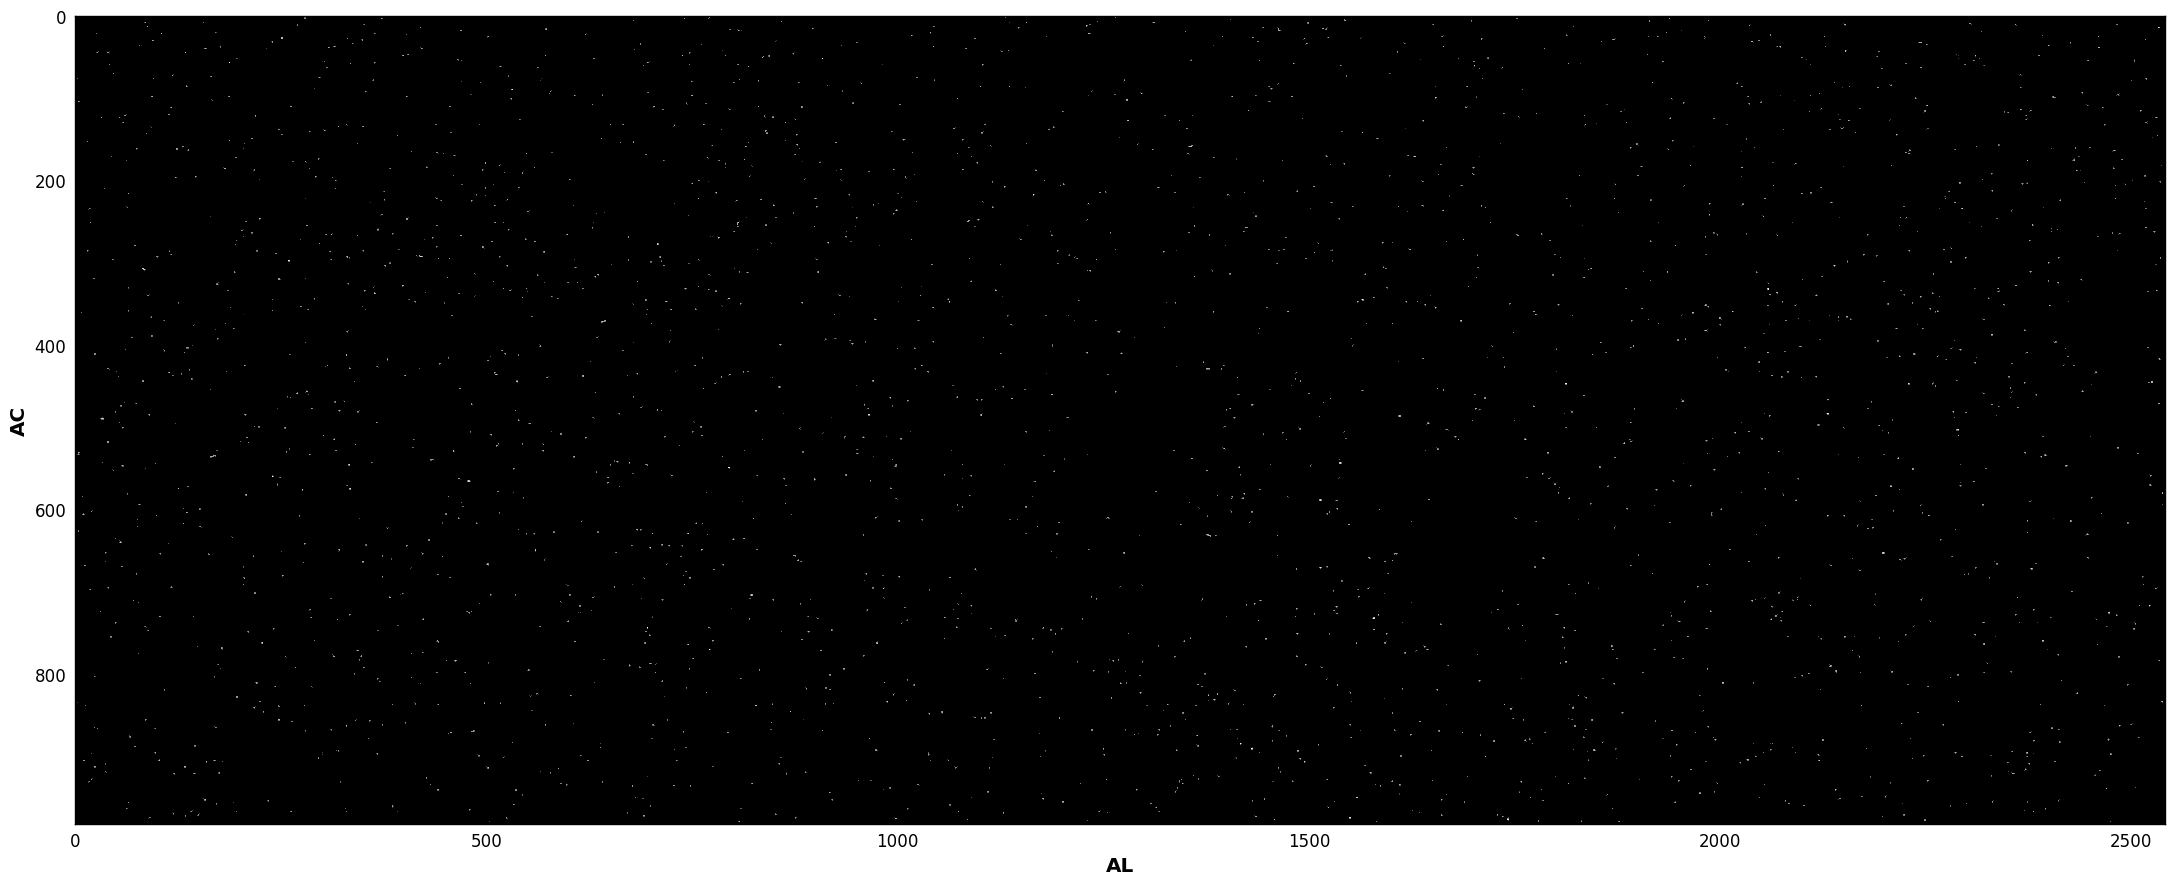

In [43]:
im=np.flip(np.rot90(obsimg,1),0)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='gray',norm=LogNorm())
#plt.imshow(image[30:60,70:120], cmap='gray')
plt.gcf().set_size_inches(30.5, 10.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

In [31]:
print(sourcefiles[iobs])

../../datasets/sif_fits/2017-09-11/SIF_PROCESSING_CCD_ROW_4_SM2_OBMT_START_122106216998685500_CDP_NONE.fits
